In [1]:
import pandas as pd
import numpy as np

import sys
sys.path.append("")
sys.path.append("../../")
import glob
import os
import matplotlib.pyplot as plt
import time
import pickle

In [2]:
for x in zip(glob.glob("..\\data\\M4test\\*"), glob.glob("..\\data\\M4train\\*")):
    print(x)

('..\\data\\M4test\\Daily-test.csv', '..\\data\\M4train\\Daily-train.csv')
('..\\data\\M4test\\Hourly-test.csv', '..\\data\\M4train\\Hourly-train.csv')
('..\\data\\M4test\\Monthly-test.csv', '..\\data\\M4train\\Monthly-train.csv')
('..\\data\\M4test\\Quarterly-test.csv', '..\\data\\M4train\\Quarterly-train.csv')
('..\\data\\M4test\\Weekly-test.csv', '..\\data\\M4train\\Weekly-train.csv')
('..\\data\\M4test\\Yearly-test.csv', '..\\data\\M4train\\Yearly-train.csv')


In [3]:
os.getcwd()

print(glob.glob("../*"))

['..\\data', '..\\env', '..\\LICENSE', '..\\notebooks', '..\\README.md']


In [4]:
df_test = pd.read_csv("..\\data\\M4test\\Yearly-test.csv", index_col=0)
df_train = pd.read_csv("..\\data\\M4train\\Yearly-train.csv", index_col=0)

In [5]:
len(df_test), len(df_test.columns), len(df_train), len(df_train.columns)

(23000, 6, 23000, 835)

In [6]:
df_train.head(), df_test.head()

(        V2      V3      V4      V5      V6      V7      V8      V9     V10  \
 V1                                                                           
 Y1  5172.1  5133.5  5186.9  5084.6  5182.0  5414.3  5576.2  5752.9  5955.2   
 Y2  2070.0  2104.0  2394.0  1651.0  1492.0  1348.0  1198.0  1192.0  1105.0   
 Y3  2760.0  2980.0  3200.0  3450.0  3670.0  3850.0  4000.0  4160.0  4290.0   
 Y4  3380.0  3670.0  3960.0  4190.0  4440.0  4700.0  4890.0  5060.0  5200.0   
 Y5  1980.0  2030.0  2220.0  2530.0  2610.0  2720.0  2970.0  2980.0  3100.0   
 
        V11  ...  V827  V828  V829  V830  V831  V832  V833  V834  V835  V836  
 V1          ...                                                              
 Y1  6087.8  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
 Y2  1008.0  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
 Y3  4530.0  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
 Y4  5490.0  ...   NaN   NaN   NaN   NaN   NaN   N

In [7]:
df = df_train.join(df_test, lsuffix="train", rsuffix="test")
Y = df.to_numpy()

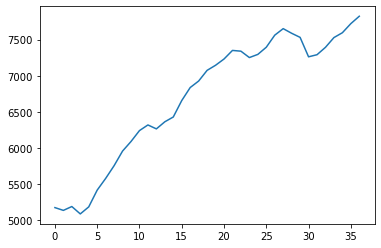

In [8]:
plt.plot(df.loc["Y1"].dropna().to_numpy())

In [9]:
def sample_series(X, look_back=10):
    """
    Create a sample and label from a data matrix.
    """
    i = np.random.randint(X.shape[0])
    s = Y[i][~np.isnan(Y[i])]
    if look_back > len(s):
        look_back = len(s) - 1
    j = np.random.randint(look_back, len(s))
    sample = s[j-look_back : j]
    label = s[j]
    assert len(sample) == look_back
    return sample, label

sample_series(Y)

(array([1003., 1114., 1191., 1261., 1175., 1030.,  915.,  741.,  765.,
         728.]),
 744.0)

In [22]:
samples_Y = []
start = time.time()
for lb in [i for i in range(1,16)]:
    print(lb)
    for n in range(100000):
        samples_Y.append(sample_series(Y, look_back=lb))
print(time.time() - start)
len(samples_Y)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
44.08230662345886


1500000

In [23]:
with open("train.pkl", "wb") as f:
    pickle.dump(samples_Y, f)

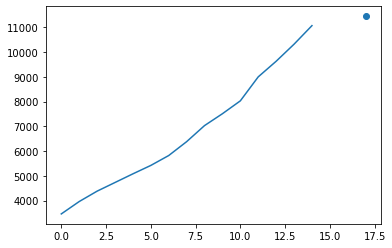

In [24]:
plt.plot(samples_Y[-1][0])
plt.scatter(17,samples_Y[-1][1])

In [17]:
s = np.random.randn(5)
s[1:3], s[3]

(array([0.31936931, 0.18815443]), -0.9596519075085506)

In [18]:
np.random.randint(Y.shape[0])

20378